#Translators

In [1]:
tr = {'uint8': 'B', 'uint32': 'I',
      'int32': 'i', 'int16': 'h',
      'uint16': 'H','int8': 'b'}

sizeOf = {'uint8': 1, 'uint32': 4,
          'int32': 4, 'int16': 2,
          'uint16': 2,'int8': 1}

#Parameters

In [2]:
chunkSize = 2068
ECIFrameOfReference = 'J2000'
timeSince = '1 Jan 2000 00:00:00.000000'

#Import libraries

In [3]:
import pandas as pd
import numpy as np
from struct import unpack
import matplotlib.pyplot as plt

#Read TLM List and prepare parser

In [4]:
tlmList = pd.read_csv('TLM_LIST.csv')
tlmList = tlmList.dropna()
dtype = list(tlmList.loc[:]['Tlm Type'])
frm = '>'+''.join([tr.get(dt,None) for dt in dtype])

#Read binary data

In [5]:
with open("telemetry.bin", "rb") as f:
    telemetry = f.read()
nrOfPoints = int(len(telemetry)/chunkSize)

#Translate bin to int

In [6]:
firstByte = int(tlmList['Byte'].iloc[0])
lastByte = int(tlmList['Byte'].iloc[-1] + sizeOf[tlmList['Tlm Type'].iloc[-1]])
a = []
for i in range(int(len(telemetry)/chunkSize)):
    chunk = telemetry[i*chunkSize:(i+1)*chunkSize]
    a.append(unpack(frm,chunk[firstByte:lastByte]))

#Get interesting data. Yes I could have saved this data in variables.

#24 - Time
#38,39,40 position x,y,z
#75,76,77,78 Attitude Quaternions

In [7]:
results_np = np.array(a)
converter = np.array(tlmList.loc[:]['Tlm Conversion (EU/lsb)'])
results_np = np.multiply(results_np,converter)
results = results_np
mask = results_np[:,29]*results_np[:,93]== 1
results_np = results_np[mask,:]

In [9]:
#I assume that data in binary file are in correct order
#results_np = np.unique(results_np,axis=0)
#results_np = results_np[np.argsort(results_np[:, 24])]

#Time Validation

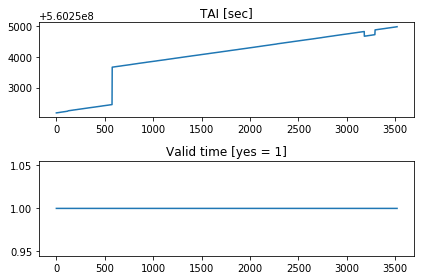

In [10]:
fig, (ax1,ax2) = plt.subplots(2)
ax1.plot(results_np[:,24])
ax1.set_title('TAI [sec]')
ax2.plot(results_np[:,29])
ax2.set_title('Valid time [yes = 1]')
fig.tight_layout()

In [11]:
# Time in ephemeris should be in ascending order...

#Position Validation

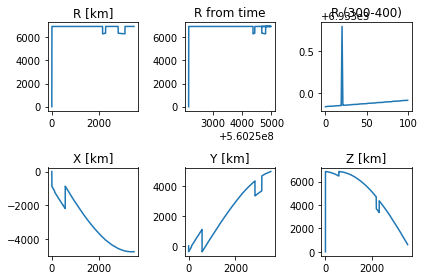

In [12]:
r = (results_np[:,38]**2 + results_np[:,39]**2 + results_np[:,40]**2)**0.5
fig, ax = plt.subplots(2,3)
ax[0,0].plot(r)
ax[0,0].set_title('R [km]')
ax[1,0].plot(results_np[:,38])
ax[1,0].set_title('X [km]')
ax[1,1].plot(results_np[:,39])
ax[1,1].set_title('Y [km]')
ax[1,2].plot(results_np[:,40])
ax[1,2].set_title('Z [km]')
ax[0,2].plot(r[300:400])
ax[0,2].set_title('R (300-400)')
ax[0,1].plot(results_np[:,24],r)
ax[0,1].set_title('R from time')
fig.tight_layout()

In [13]:
#Looks like we have some problem with data.
#Rapid changes in distance are impossible for satellite. Look R (300-400)
#Looks like sometimes there were errors in position measurements
#I don't find records with information about error in positions
#so I leve all data as they are in the binary file.

#Position in 3D

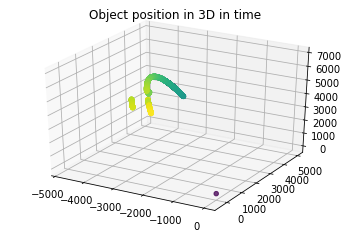

In [14]:
from mpl_toolkits.mplot3d import Axes3D

x = results_np[:,38]
y = results_np[:,39]
z = results_np[:,40]
t = results_np[:,24]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Object position in 3D in time') 
ax.scatter(x, y, z, c=t, marker='o')

plt.show()

In [15]:
#Looks like we have 2 orbits and one point in the Earth centre.

#Attitude Valdation

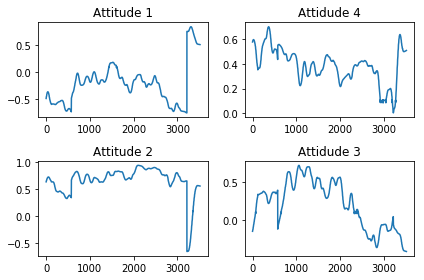

In [16]:
fig, ax = plt.subplots(2,2)
ax[0,0].plot(results_np[:,75])
ax[0,0].set_title('Attitude 1')
ax[1,0].plot(results_np[:,76])
ax[1,0].set_title('Attitude 2')
ax[1,1].plot(results_np[:,77])
ax[1,1].set_title('Attidude 3')
ax[0,1].plot(results_np[:,78])
ax[0,1].set_title('Attidude 4')
fig.tight_layout()

#number of unique times and 

In [18]:
test= list(results_np[:,24])
print("unique times: {} \ntimes: {}".format(len(set(test)), len(test)))

unique times: 3457 
times: 3520


#Prepere ephemeris file

In [19]:
formatOfData = 'AttitudeTimeQuaternions'
typeOfFile = 'Attitude'

hd = f"""stk.v.12.0
BEGIN {typeOfFile}
NumberOfEphemerisPoints	 \t{len(results_np)}
ScenarioEpoch \t{timeSince}
CoordinateAxesEpoch \t{timeSince}
CoordinateAxes \t{ECIFrameOfReference}
{formatOfData}
"""

ft = f"""END {typeOfFile}"""

np.savetxt("attitudes_1.a", results_np[:500,(24,75,76,77,78)], delimiter=" ", header = hd,
           footer = ft, comments = '')
np.savetxt("attitudes_2.a", results_np[500:,(24,75,76,77,78)], delimiter=" ", header = hd,
           footer = ft, comments = '')

In [20]:
formatOfData = 'EphemerisTimePos'
typeOfFile = 'Ephemeris'

hd = f"""stk.v.12.0
BEGIN {typeOfFile}
NumberOfEphemerisPoints	 \t{len(results_np)}
ScenarioEpoch \t{timeSince}
CoordinateSystem \t{ECIFrameOfReference}
DistanceUnit Kilometers
InterpolationSamplesM1 5
{formatOfData}
"""

ft = f"""END {typeOfFile}"""

np.savetxt("ephemeris_1.e", results_np[:500,(24,38,39,40)], delimiter=" ", header = hd,
           footer = ft, comments = '')
np.savetxt("ephemeris_2.e", results_np[500:,(24,38,39,40)], delimiter=" ", header = hd,
           footer = ft, comments = '')

#Splits ephemeris in two parts was arbitrary.